In [1]:
!pip install transformers
!pip install pandas as pd
!pip install numpy as np
!pip install torch
!pip install sklearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 68.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 80.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 35.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 32.3 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement as (from versions: none)
ERROR: No matching distribution found for as
ERROR: Could not find a version that satisfies the requirement as (from versions: none)
ERROR: No matching distribution found for as
  Preparing metadata (setup.py) ... done
  Created wheel for sklearn: filename=sklearn-0.0.post10-py3-none-any.whl size=2959 sha256=40a126d88f3ab0c93081487c4024dbb37c717d10f01d9eba307d8bc2c11ae766
  Stored in directory: /root/.cache/pip/wheels/5b/f6/92/0173054cc528db7ffe7b0c7652a96c3102aab156a6da960387
Successfully built sklearn


In [2]:
!pip install accelerate -U
!pip install --upgrade transformers
!pip install --upgrade torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 69.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 69.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 99.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.8/209.8 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

In [10]:
from google.colab import files
uploaded = files.upload()

Saving halloween_movies.csv to halloween_movies.csv


In [41]:
from transformers import AutoTokenizer, DataCollatorWithPadding, TrainingArguments, AutoModelForSequenceClassification, Trainer
from torch.utils.data import Dataset
import pandas as pd
import numpy as np
import torch
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import random
from tqdm import tqdm_notebook as tqdm
import seaborn as sn
import matplotlib.pyplot as plt

In [4]:
class CustomDataset(Dataset):
    def __init__(
            self,
            encodings,
            labels,):

        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])

        return item

    def __len__(self):
        return len(self.labels)

In [5]:
def train_test_val_split(inputs, labels, ratios):
    train_inputs, test_inputs, train_labels, test_labels = train_test_split(inputs, labels, train_size=ratios[0])
    ratios[1] = ratios[1]/(1-ratios[0])
    ratios[2] = ratios[2]/(1-ratios[0])
    test_inputs, val_inputs, test_labels, val_labels = train_test_split(test_inputs, test_labels,train_size = ratios[1])

    return train_inputs, train_labels, test_inputs, test_labels, val_inputs, val_labels

In [6]:
def preprocess(dataframe, max_size, ratios, tokenizer):
    inputs = dataframe["Full Description"].tolist()[:max_size]
    labels = dataframe["Labels"].tolist()[:max_size]

    train_inputs, train_labels, test_inputs, test_labels, val_inputs, val_labels = train_test_val_split(inputs,labels, ratios)

    return (
        tokenizer(train_inputs, truncation=True),
        train_labels,
        tokenizer(test_inputs, truncation=True),
        test_labels,
        tokenizer(val_inputs, truncation=True),
        val_labels
    )

In [7]:
def load_data(file_name):
    data = pd.read_csv(file_name)

    return data

In [8]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    report = metrics.classification_report(y_pred=predictions, y_true=labels, digits=4, output_dict=True)

    return {
        "f1": report["macro avg"]["f1-score"],
        "accuracy": report["accuracy"]
    }

In [49]:
def evaluate(trainer, test_dataset):
  outputs = trainer.predict(test_dataset)
  pred = np.argmax(outputs.predictions,axis=1)
  labels = outputs.label_ids
  cm = confusion_matrix(labels,pred)

  sn.set(font_scale=1)
  sn.heatmap(cm, annot=True, annot_kws={"size": 16})

  plt.show()

  print(f"Metrics: {outputs.metrics}")




In [19]:
data = load_data("halloween_movies.csv")

tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

train_embeddings, train_labels, test_embeddings, test_labels, val_embeddings, val_labels = preprocess(data,8000,[0.6,0.2,0.2],tokenizer)

train_dataset = CustomDataset(train_embeddings, train_labels)
test_dataset = CustomDataset(test_embeddings, test_labels)
val_dataset = CustomDataset(val_embeddings, val_labels)

print(f'The first element in each dataset')
print(train_dataset[0], end='\n\n')
print(test_dataset[0], end='\n\n')
print(val_dataset[0], end='\n\n')

print(f'Length of train dataset: {len(train_dataset)}')
print(f'Length of test dataset: {len(test_dataset)}')
print(f'Length of val dataset: {len(val_dataset)}')

The first element in each dataset
{'input_ids': tensor([  101,  1000,  3280,  2226, 21442,  6895,   999,  1000,  1006,  2289,
         1007,  3280,  2226, 21442,  6895,  1012,  9765, 16655,  8668, 10093,
         6777,  5562,  2063,  5447, 23565, 15581,  4402,  2139,  2474,  8668,
        17151, 21493,  9013,  2638,  1005,  4067,  2643,  2017,  1005,  2128,
         2182,  1005,  1012,  1048,  1005, 15760,  9765,  8750,  2063, 11968,
         4388, 16183,  3567,  4014,  1010, 21864,  9765, 17151,  5332,  4895,
         4078, 25527,  4031, 26744,  1010,  3802, 28105,  2063,  2139, 14289,
         2483,  3393,  2676, 17419,  6633, 13578,  2289, 18414,  2015, 28940,
         1005,  4372,  2262,  7505,  2694,  2050,  1012, 24209,  4017,  2890,
         2711, 12032,  7616,  2777,  6528,  2102,  4372,  3350,  3393,  3126,
         5848,  1040,  1005,  2552, 11236,  1010,  3231,  4765,  3393,  3126,
        12411,  2015,  2139,  2474, 16360,  8445,  2666,  3802,  1010,  7505,
        24826,  

In [66]:
# Our model and other stuff!!
id2label = {0: "Normal", 1: "Halloween"}
label2id = {"Normal": 0, "Halloween": 1}

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2, id2label=id2label, label2id=label2id
)

data_collater = DataCollatorWithPadding(tokenizer=tokenizer)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
# Make sure cuda is set up
torch.cuda.is_available()

True

In [70]:
# TIME TO TRAIN IT!!!!
training_args = TrainingArguments(
    disable_tqdm=True,
    output_dir="movie_classification",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collater,
    compute_metrics=compute_metrics,
)

trainer.train()

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'loss': 0.3026, 'learning_rate': 1e-05, 'epoch': 1.0}
{'eval_loss': 0.21997018158435822, 'eval_f1': 0.9212469237079574, 'eval_accuracy': 0.92125, 'eval_runtime': 16.4115, 'eval_samples_per_second': 97.493, 'eval_steps_per_second': 6.093, 'epoch': 1.0}
{'loss': 0.1613, 'learning_rate': 0.0, 'epoch': 2.0}
{'eval_loss': 0.21202558279037476, 'eval_f1': 0.9324391952757481, 'eval_accuracy': 0.9325, 'eval_runtime': 16.5676, 'eval_samples_per_second': 96.574, 'eval_steps_per_second': 6.036, 'epoch': 2.0}
{'train_runtime': 329.8439, 'train_samples_per_second': 29.105, 'train_steps_per_second': 1.819, 'train_loss': 0.2319809913635254, 'epoch': 2.0}


TrainOutput(global_step=600, training_loss=0.2319809913635254, metrics={'train_runtime': 329.8439, 'train_samples_per_second': 29.105, 'train_steps_per_second': 1.819, 'train_loss': 0.2319809913635254, 'epoch': 2.0})

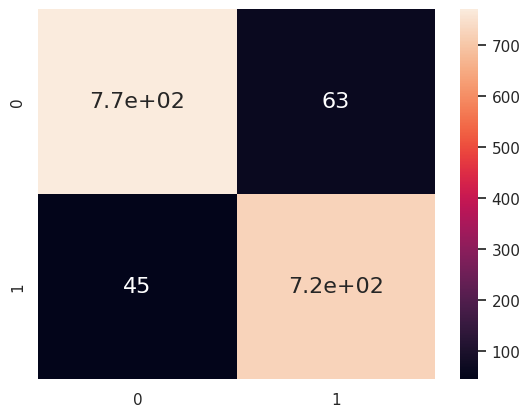

Metrics: {'test_loss': 0.21202558279037476, 'test_f1': 0.9324391952757481, 'test_accuracy': 0.9325, 'test_runtime': 16.2819, 'test_samples_per_second': 98.269, 'test_steps_per_second': 6.142}


In [71]:
evaluate(trainer,test_dataset)

In [73]:
# TIME FOR SOME INFERENCE!!!
device = torch.device('cuda')
model.to(device)

text = "A Quiet Place(2018) A family struggles for survival in a world where most humans have been killed by blind but noise-sensitive creatures. They are forced to communicate in sign language to keep the creatures at bay"
inputs = tokenizer(text, return_tensors="pt").to(device)

with torch.no_grad():
  logits = model(**inputs).logits
  predicted_class_id = logits.argmax().item()
  print(model.config.id2label[predicted_class_id])

Halloween
